In [1]:
import warnings
warnings.filterwarnings("ignore", "in-band")

import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPUBatch#DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *

import sealgw
import lal

import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
#ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(['H1', 'L1', 'V1', 'ET', 'CE','CEL'])
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

In [3]:
det = ifos[0]

In [4]:
det.geometry.detector_tensor

array([[-0.3926141 , -0.07761341, -0.24738904],
       [-0.07761341,  0.31952407,  0.22799783],
       [-0.24738904,  0.22799783,  0.07309003]])

In [5]:
det.vertex

array([-2161414.92636   , -3834695.17888835,  4600350.22663899])

In [6]:
class GWAntennaOnCPU():
    def __init__(self, detector_names, gmst_fit = False, gps_start=None, gps_end=None):
        self.ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(detector_names)
        self.gmst_fit = gmst_fit 
        if gmst_fit:
            self.fit_linear_approx_gmst(gps_start, gps_end)

    def fit_linear_approx_gmst(self, gps_start, gps_end):
        t = np.linspace(gps_start, gps_end, 100000)
        gmst=[]
        for tt in t:
            gmst.append(bilby.gw.utils.greenwich_mean_sidereal_time(tt))
        gmst = np.array(gmst)
        self.k, self.b = np.polyfit(t, gmst, 1)
        self.gmst_fit = True

        # validate the accuracy of linear fit 
        #t_test = np.linspace(gps_start, gps_end, 13417)
        t_test = t
        gmst_fit = self.k * t_test + self.b
        #gmst_true = []
        #for tt in t_test:
        #    gmst_true.append(bilby.gw.utils.greenwich_mean_sidereal_time(tt))
        #gmst_true = np.array(gmst_true)
        gmst_true = gmst 
        err = np.max(np.abs(gmst_true - gmst_fit))
        print(f"Max error in linear fit of gmst: {err}")
        

    def getgha(self, gpstime, ra):
        # Greenwich hour angle of source (radians).
        gha = np.zeros_like(gpstime) - ra

        if self.gmst_fit:
            gha += (self.k * gpstime + self.b)
        else:
            for i,gpst in enumerate(gpstime):
                gha[i] += bilby.gw.utils.greenwich_mean_sidereal_time(gpst)
        return gha
    
    def response(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]
        
        X = np.zeros((bs, 3))
        Y = np.zeros((bs, 3))

        
        gha = self.getgha(gpstime, ra)

        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        cospsi = np.cos(psi)
        sinpsi = np.sin(psi)
    
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec
        
        resp_dict = {}
        for det in self.ifos:
            D = det.detector_tensor
            fp = np.einsum('ij,jk,ik->i', X, D, X) - np.einsum('ij,jk,ik->i', Y, D, Y)
            fc = np.einsum('ij,jk,ik->i', X, D, Y) + np.einsum('ij,jk,ik->i', Y, D, X)
            resp_dict[det.name] = (fp, fc)

        return resp_dict
    
    def time_delay_from_geocenter(self, ra, dec, gpstime):
        bs = ra.shape[0]
        gha = self.getgha(gpstime, ra)
        
        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        
        wavevector = np.zeros((bs, 3))
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -cosgha*cosdec, cosdec*singha, -sindec
        
        dt_dict = {}
        for det in self.ifos:
            loc = det.vertex
            dt = np.einsum('ij,j->i', wavevector, loc) / 299792458
            dt_dict[det.name] = dt
        
        return dt_dict

    def resp_and_dt(self, ra, dec, gpstime, psi):
        bs = ra.shape[0]        
        X = np.zeros((bs, 3))
        Y = np.zeros((bs, 3))

        gha = self.getgha(gpstime, ra)

        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        cospsi = np.cos(psi)
        sinpsi = np.sin(psi)
        
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec

        
        
        wavevector = np.zeros((bs, 3))
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -cosgha*cosdec, cosdec*singha, -sindec
        
        resp_and_dt_dict = {}
        for det in self.ifos:
            loc = det.vertex
            D = det.detector_tensor
            
            fp = np.einsum('ij,jk,ik->i', X, D, X) - np.einsum('ij,jk,ik->i', Y, D, Y)
            fc = np.einsum('ij,jk,ik->i', X, D, Y) + np.einsum('ij,jk,ik->i', Y, D, X)
            dt = np.einsum('ij,j->i', wavevector, loc) / 299792458
            resp_and_dt_dict[det.name] = [fp,fc,dt]

        return resp_and_dt_dict




class GWAntennaOnGPU():
    def __init__(self, detector_names, gmst_fit=False, gps_start=None, gps_end=None, device='cuda', dtype=torch.float64):
        self.ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(detector_names)
        self.gmst_fit = gmst_fit
        self.device = device
        self.dtype = dtype
        if gmst_fit:
            self.fit_linear_approx_gmst(gps_start, gps_end)

    def fit_linear_approx_gmst(self, gps_start, gps_end):
        t = np.linspace(gps_start, gps_end, 100000).astype(np.float64)
        gmst = []
        for tt in t:
            gmst.append(bilby.gw.utils.greenwich_mean_sidereal_time(tt))
        gmst = np.array(gmst)
        self.k, self.b = np.polyfit(t, gmst, 1)
        self.gmst_fit = True

        # validate the accuracy of linear fit
        t_test = t
        gmst_fit = self.k * t_test + self.b
        gmst_true = gmst
        err = np.max(np.abs(gmst_true - gmst_fit))
        print(f"Max error in linear fit of gmst: {err}")
        
        self.k = torch.tensor(self.k).to(self.device).type(self.dtype)
        self.b = torch.tensor(self.b).to(self.device).type(self.dtype)

    def getgha(self, gpstime, ra):
        # Greenwich hour angle of source (radians).
        gha = torch.zeros_like(gpstime, device=self.device, dtype=self.dtype) - ra

        if self.gmst_fit:
            gha += (self.k * gpstime + self.b)
        else:
            for i, gpst in enumerate(gpstime):
                gha[i] += bilby.gw.utils.greenwich_mean_sidereal_time(gpst)
        return gha

    def response(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]

        X = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        Y = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)

        gha = self.getgha(gpstime, ra)

        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)
        cospsi = torch.cos(psi)
        sinpsi = torch.sin(psi)

        X[:, 0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:, 1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:, 2] = sinpsi * cosdec

        Y[:, 0] = sinpsi * singha - cospsi * cosgha * sindec
        Y[:, 1] = sinpsi * cosgha + cospsi * singha * sindec
        Y[:, 2] = cospsi * cosdec

        resp_dict = {}
        for det in self.ifos:
            D = torch.from_numpy(det.detector_tensor).to(self.device).type(self.dtype)
            fp = torch.einsum('ij,jk,ik->i', X, D, X) - torch.einsum('ij,jk,ik->i', Y, D, Y)
            fc = torch.einsum('ij,jk,ik->i', X, D, Y) + torch.einsum('ij,jk,ik->i', Y, D, X)
            resp_dict[det.name] = (fp, fc)

        return resp_dict

    def time_delay_from_geocenter(self, ra, dec, gpstime):
        bs = ra.shape[0]
        gha = self.getgha(gpstime, ra)

        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)

        wavevector = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        wavevector[:, 0], wavevector[:, 1], wavevector[:, 2] = \
            -cosgha * cosdec, cosdec * singha, -sindec

        dt_dict = {}
        for det in self.ifos:
            loc = torch.from_numpy(det.vertex).to(self.device).type(self.dtype)
            dt = torch.einsum('ij,j->i', wavevector, loc) / 299792458
            dt_dict[det.name] = dt

        return dt_dict

    def resp_and_dt(self, ra, dec, gpstime, psi):
        bs = ra.shape[0]
        X = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        Y = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)

        gha = self.getgha(gpstime, ra)

        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)
        cospsi = torch.cos(psi)
        sinpsi = torch.sin(psi)

        X[:, 0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:, 1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:, 2] = sinpsi * cosdec

        Y[:, 0] = sinpsi * singha - cospsi * cosgha * sindec
        Y[:, 1] = sinpsi * cosgha + cospsi * singha * sindec
        Y[:, 2] = cospsi * cosdec

        wavevector = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        wavevector[:, 0], wavevector[:, 1], wavevector[:, 2] = \
            -cosgha * cosdec, cosdec * singha, -sindec


        wavevector = wavevector.detach()
        resp_and_dt_dict = {}
        for det in self.ifos:
            loc = torch.from_numpy(det.vertex).to(self.device).type(self.dtype)
            D = torch.from_numpy(det.detector_tensor).to(self.device).type(self.dtype)
            
            fp = torch.einsum('ij,jk,ik->i', X, D, X) - torch.einsum('ij,jk,ik->i', Y, D, Y)
            fc = torch.einsum('ij,jk,ik->i', X, D, Y) + torch.einsum('ij,jk,ik->i', Y, D, X)
            dt = torch.einsum('ij,j->i', wavevector, loc) / 299792458.0
            resp_and_dt_dict[det.name] = [fp, fc, dt]


        return resp_and_dt_dict


In [18]:
class GWAntennaOnGPU2():
    def __init__(self, detector_names, gmst_fit=False, gps_start=None, gps_end=None, device='cuda', dtype=torch.float64):
        self.ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(detector_names)
        self.gmst_fit = gmst_fit
        self.device = device
        self.dtype = dtype
        if gmst_fit:
            self.fit_linear_approx_gmst(gps_start, gps_end)
        self.locs = torch.stack([torch.from_numpy(det.vertex).to(self.device).type(self.dtype) for det in self.ifos])
        self.Ds = torch.stack([torch.from_numpy(det.detector_tensor).to(self.device).type(self.dtype) for det in self.ifos])

    def fit_linear_approx_gmst(self, gps_start, gps_end):
        t = np.linspace(gps_start, gps_end, 100000).astype(np.float64)
        gmst = []
        for tt in t:
            gmst.append(bilby.gw.utils.greenwich_mean_sidereal_time(tt))
        gmst = np.array(gmst)
        self.k, self.b = np.polyfit(t, gmst, 1)
        self.gmst_fit = True

        # validate the accuracy of linear fit
        t_test = t
        gmst_fit = self.k * t_test + self.b
        gmst_true = gmst
        err = np.max(np.abs(gmst_true - gmst_fit))
        print(f"Max error in linear fit of gmst: {err}")
        
        self.k = torch.tensor(self.k).to(self.device).type(self.dtype)
        self.b = torch.tensor(self.b).to(self.device).type(self.dtype)

    def getgha(self, gpstime, ra):
        # Greenwich hour angle of source (radians).
        gha = torch.zeros_like(gpstime, device=self.device, dtype=self.dtype) - ra

        if self.gmst_fit:
            gha += (self.k * gpstime + self.b)
        else:
            for i, gpst in enumerate(gpstime):
                gha[i] += bilby.gw.utils.greenwich_mean_sidereal_time(gpst)
        return gha

    def resp_and_dt(self, ra, dec, gpstime, psi):
        bs = ra.shape[0]
        X = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        Y = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)

        gha = self.getgha(gpstime, ra)

        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)
        cospsi = torch.cos(psi)
        sinpsi = torch.sin(psi)

        X[:, 0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:, 1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:, 2] = sinpsi * cosdec

        Y[:, 0] = sinpsi * singha - cospsi * cosgha * sindec
        Y[:, 1] = sinpsi * cosgha + cospsi * singha * sindec
        Y[:, 2] = cospsi * cosdec

        wavevector = torch.zeros((bs, 3), device=self.device, dtype=self.dtype)
        wavevector[:, 0], wavevector[:, 1], wavevector[:, 2] = \
            -cosgha * cosdec, cosdec * singha, -sindec

        wavevector = wavevector.detach()

        fps = torch.einsum('ij,ajk,ik->ia', X, self.Ds, X) - torch.einsum('ij,ajk,ik->ia', Y, self.Ds, Y)
        fcs = torch.einsum('ij,ajk,ik->ia', X, self.Ds, Y) + torch.einsum('ij,ajk,ik->ia', Y, self.Ds, X)
        dts = torch.einsum('ij,aj->ia', wavevector, self.locs) / 299792458.0

        resp_and_dt_dict = {det.name: [fp, fc, dt] for det, fp, fc, dt in zip(self.ifos, fps.T, fcs.T, dts.T)}

        return resp_and_dt_dict

In [19]:
detnames = ['H1', 'L1', 'V1', 'ET', 'CE','CEL']
device = 'cuda'
at_cpu = GWAntennaOnCPU(detector_names=detnames)
at_cpu_approx = GWAntennaOnCPU(detector_names=detnames, gmst_fit=True, gps_start=0, gps_end=40000)
at_gpu_approx = GWAntennaOnGPU(detector_names=detnames, gmst_fit=True, gps_start=0, gps_end=40000,
                              device=device, dtype=torch.float64)
at_gpu_approx2 = GWAntennaOnGPU2(detector_names=detnames, gmst_fit=True, gps_start=0, gps_end=40000,
                              device=device, dtype=torch.float64)


Max error in linear fit of gmst: 1.4915713109076023e-09
Max error in linear fit of gmst: 1.4915713109076023e-09
Max error in linear fit of gmst: 1.4915713109076023e-09


In [10]:
Ntest  = 1024*6000
#Ntest  = 100

test_ra = np.linspace(0,2,Ntest)
test_dec = np.linspace(-1.5,1.5,Ntest)
test_psi = np.linspace(0,3,Ntest)
test_tc = np.linspace(0,30000,Ntest)

test_ra_gpu = torch.from_numpy(test_ra).to(device)
test_dec_gpu = torch.from_numpy(test_dec).to(device)
test_psi_gpu = torch.from_numpy(test_psi).to(device)
test_tc_gpu = torch.from_numpy(test_tc).to(device)

In [13]:
t1 = time.time()
resp_and_dt_dict_cpu = at_cpu.resp_and_dt(test_ra, test_dec, test_psi, test_tc)
t2 = time.time()

print(t2-t1)

72.33176851272583


In [14]:
t1 = time.time()
resp_and_dt_dict_cpu_approx = at_cpu_approx.resp_and_dt(test_ra, test_dec, test_psi, test_tc)
t2 = time.time()

print(t2-t1)

66.31053829193115


In [20]:
t1 = time.time()
resp_and_dt_dict_gpu_approx = at_gpu_approx.resp_and_dt(test_ra_gpu, test_dec_gpu, test_psi_gpu, test_tc_gpu)
t2 = time.time()

print(t2-t1)

0.5746316909790039


In [21]:
t1 = time.time()
resp_and_dt_dict_gpu_approx2 = at_gpu_approx2.resp_and_dt(test_ra_gpu, test_dec_gpu, test_psi_gpu, test_tc_gpu)
t2 = time.time()

print(t2-t1)

0.006478548049926758


In [175]:
for detname in resp_and_dt_dict_cpu_approx.keys():
    error = np.array(resp_and_dt_dict_cpu_approx[detname]) - np.array(resp_and_dt_dict_cpu[detname])
    print(np.max(abs(error)))

1.6555820603336713e-09
1.2181918251918944e-09
1.653243986154962e-09
1.1267644040025004e-09
1.5250927326571073e-09
1.3846087054680822e-09
1.6556176429816105e-09
1.2181918251918944e-09


In [180]:
for detname in resp_and_dt_dict_cpu_approx.keys():
    for i in range(3):
        gpu_result = np.array(torch.tensor(resp_and_dt_dict_gpu_approx[detname][i]).cpu())
        cpu_result = resp_and_dt_dict_cpu_approx[detname][i]
        error = np.array(cpu_result) - np.array(gpu_result)
        print(np.max(abs(error)))

<ipython-input-180-638f8968bb8d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpu_result = np.array(torch.tensor(resp_and_dt_dict_gpu_approx[detname][i]).cpu().type(torch.float32))


2.9802232681674923e-08
2.9802294743142e-08
4.656612699605045e-10
2.980231328386651e-08
2.9802320167249263e-08
4.656609819964075e-10
2.980231139648737e-08
2.980229618643193e-08
9.313224115514718e-10
2.9802305290260733e-08
2.9802303069814684e-08
9.313224115514718e-10
2.9802306844572968e-08
2.9802282419666426e-08
9.313220576678827e-10
2.9802309731152832e-08
2.9802305290260733e-08
9.313225642071377e-10
2.9802319390093146e-08
2.9802320611338473e-08
4.656612699605045e-10
2.980231328386651e-08
2.9802320167249263e-08
4.656609819964075e-10


In [23]:
for detname in resp_and_dt_dict_cpu_approx.keys():
    for i in range(3):
        gpu_result = np.array(torch.tensor(resp_and_dt_dict_gpu_approx2[detname][i]).cpu())
        cpu_result = resp_and_dt_dict_cpu_approx[detname][i]
        error = np.array(cpu_result) - np.array(gpu_result)
        print(np.max(abs(error)))

<ipython-input-23-74cf5f536045>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpu_result = np.array(torch.tensor(resp_and_dt_dict_gpu_approx2[detname][i]).cpu())


5.551115123125783e-16
6.661338147750939e-16
6.938893903907228e-18
5.551115123125783e-16
6.661338147750939e-16
8.673617379884035e-18
6.661338147750939e-16
7.771561172376096e-16
6.938893903907228e-18
6.661338147750939e-16
6.661338147750939e-16
6.938893903907228e-18
6.661338147750939e-16
6.661338147750939e-16
1.0408340855860843e-17
6.661338147750939e-16
5.551115123125783e-16
1.0408340855860843e-17
5.551115123125783e-16
6.661338147750939e-16
6.938893903907228e-18
5.551115123125783e-16
6.661338147750939e-16
8.673617379884035e-18


In [56]:
t1 = time.time()
resp_and_dt_dict_real = {}

for det in tt.ifos:
    fp_real = []
    fc_real = []
    dt_real = []

    for i in range(Ntest):
        fp_real.append(det.antenna_response(test_ra[i], test_dec[i], test_tc[i], test_psi[i], 'plus'))
        fc_real.append(det.antenna_response(test_ra[i], test_dec[i], test_tc[i], test_psi[i], 'cross'))
        dt_real.append(det.time_delay_from_geocenter(test_ra[i], test_dec[i], test_tc[i]))

    fp_real = np.array(fp_real)
    fc_real = np.array(fc_real)
    dt_real = np.array(dt_real)

    resp_and_dt_dict_real[det.name] = (fp_real, fc_real, dt_real)
t2 = time.time()
print(t2-t1)

4.634796857833862


In [46]:
maxerror = 0
for det in tt.ifos:
    detname1 = det.name
    ##if detname1=='ET1':
    #    detname2 = 'ET2'
    #elif detname1=='ET2':
    #    detname2 = 'ET1'
    #else:
    #    detname2 = detname1
    tempmax = np.max(np.array(resp_and_dt_dict_real[detname1]) - np.array(resp_and_dt_dict[detname1]) )
    if maxerror<tempmax:
        print(det.name)
        maxerror = tempmax
        
print(maxerror)

H1
L1
V1
ET1
ET2
0.0016637406934446874


In [3]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

In [4]:
def loadVandVh(Vhfilepath, Nbasis):
    with open(Vhfilepath, 'rb') as f:
        Vh = pickle.load(f)
    if len(Vh)<Nbasis:
        raise ValueError(f'required Nbasis ({Nbasis}) > len(Vh) ({len(Vh)})!')
    Vh = Vh[:Nbasis]
    V = Vh.T.conj()
        
    return V, Vh

In [5]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)


06:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [6]:
class DatasetSVDStrainFDFromSVDWFonGPUBatchNew(Dataset):
    '''
    Simulate FD data in SVD space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.

    Load a batch of data, i.e. return [minibatch_size, dim1, dim2, ...]. The batch size should be 2^N. 
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, device='cuda',
                add_noise=True, minibatch_size=1, fix_extrinsic=False, shuffle=True, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.device = device
        self.minibatch_size = minibatch_size
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)

        self.antenna = GWAntennaOnCPU(data_generator.detector_names)
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        #if self.sample_per_file<self.minibatch_size:
        #    raise ValueError("Sample per file < batch size!")
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
            
        self.shuffle_indexinfile()
        
        assert self.sample_per_file % self.minibatch_size == 0
        
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whitened_V = (self.V.T * 1/(psd*det.duration/4)**0.5).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64)}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.minibatch_size

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of range")
        
        
        index = index*self.minibatch_size
        index_end = index + self.minibatch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file, is_end=True)
        
        assert index_of_file == index_of_file_end
        assert index_of_file < len(self.precalwf_filelist)

        
        wf_dict = self.get_precalwf_dict(index_of_file)
        hp_svd, hc_svd, injection_parameters = self.get_waveform_tensors_batch(wf_dict, index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_svd = hp_svd/dL
        hc_svd = hc_svd/dL

        x = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)
        theta = self.get_theta(injection_parameters)
        return theta, torch.cat((x.real, x.imag), axis=1).float()

    def get_index(self, index, sample_per_file, is_end=False):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file
        
        if is_end and index_in_file==0:
            index_in_file = None
            index_of_file -= 1
        return index_of_file, index_in_file
    
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
    
    
    def get_waveform_tensors_batch(self, wf_dict, index_in_file, index_in_file_end):

        
        index = self.random_index_in_file[index_in_file:index_in_file_end]
        hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus'][index])).type(torch.complex64).to(self.device)
        hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross'][index])).type(torch.complex64).to(self.device)
        
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        injection_parameters = injection_parameters = {key: wf_dict['injection_parameters'][key][index] for key in para_name_list}
        
        # last wf in this file
        if (index_in_file_end is None) and (self.cached_wf_file_index < len(self.precalwf_filelist)-1): 
            _ = self.get_precalwf_dict(self.cached_wf_file_index + 1)
            print('Automatically updated cached wf.')

        return hp_svd, hc_svd, injection_parameters

    def get_noise_tensors_batch(self, ):
        white_noise = (torch.randn((self.minibatch_size, self.Nbasis), device=self.device) + \
                       1j * torch.randn((self.minibatch_size, self.Nbasis), device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors_batch(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        x = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.complex64, device=self.device)
        resp_dt_dict = self.compute_detector_factors_batch(injection_parameters)
        for i,det in enumerate(self.ifos):
            detname = det.name

            fp, fc, dt = resp_dt_dict[detname]
            fp = torch.from_numpy(fp).to(self.device).unsqueeze(1)
            fc = torch.from_numpy(fc).to(self.device).unsqueeze(1)
            dt = torch.from_numpy(dt).to(self.device).unsqueeze(1)

            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray).type(torch.complex64)
            Vh_recons = self.Vh
            hh = (fp*hp_svd + fc*hc_svd).type(torch.complex64)

            hh_reconstruct = torch.einsum('ij,jk->ik', hh, Vh_recons)

            hh_shifted = hh_reconstruct * phase2add
            h_svd = torch.einsum('ij,jk->ik', hh_shifted, self.det_data[detname]['whitened_V'])

            if self.add_noise:
                n_svd = self.get_noise_tensors_batch()
                d_svd = h_svd + n_svd
            else:
                d_svd = h_svd

            x[:,i,:] = d_svd
            

        return x
    
    def compute_detector_factors_batch(self, injection_parameters):

        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        tc = injection_parameters['geocent_time']
        psi = injection_parameters['psi']

        resp_dt_dict = self.antenna.resp_and_dt(ra,dec,tc,psi)    
        dt_geocent = tc  #- self.strain_data.start_time
        for key,value in resp_dt_dict.items():
            value[2] += dt_geocent        

        return resp_dt_dict
    
    '''
    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            reduced_parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in reduced_parameter_names]), dtype=torch.float32).to(self.device).T
        else:
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device).T
        return theta
    '''

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters_batch(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + 1#np.random.uniform(0, 2*np.pi) #1
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + 1#np.arcsin(np.random.uniform(-1, 1)) #1
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + 1#np.random.uniform(0, np.pi) #1
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) 
            injection_parameters['luminosity_distance'] = np.zeros(self.minibatch_size) + 100
    
        else:
            injection_parameters['ra'] = np.random.uniform(0, 2*np.pi, self.minibatch_size)
            injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1, self.minibatch_size))
            injection_parameters['psi'] = np.random.uniform(0, np.pi, self.minibatch_size)
            injection_parameters['geocent_time'] = np.random.uniform(-0.01, 0.01, self.minibatch_size)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
        
        return injection_parameters
    
    def shuffle_wflist(self):
        #if self.shuffle:
        random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)

In [30]:
dataset_batch_new = DatasetSVDStrainFDFromSVDWFonGPUBatchNew(train_filenames[:3], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, minibatch_size=4096, device='cuda:1', shuffle=False,
                                                     add_noise=False, fix_extrinsic=False)


In [25]:
        
dataset_batch = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, minibatch_size=64, device='cuda:1', shuffle=False,
                                                     add_noise=False, fix_extrinsic=False)




In [84]:
dataset_batch.sample_per_file / 32

4096.0

In [13]:
%time theta, x = dataset_batch[0]

NameError: name 'dataset_batch' is not defined

In [14]:
%time theta_new, x_new = dataset_batch_new[0]

CPU times: user 1.31 s, sys: 17.7 ms, total: 1.33 s
Wall time: 1.17 s


In [15]:
x_new.shape

torch.Size([4096, 6, 512])

In [18]:
4096*32

131072

In [20]:
len(dataset_batch_new)

32

In [21]:
torch.max(x_new-x)

tensor(3.9339e-06, device='cuda:1')

In [32]:
batch_size = 32
dataloader = DataLoader(dataset_batch_new, batch_size=batch_size, shuffle=False)
t1 = time.time()
i=0
for theta, x in dataloader:
    i+=1
    pass
t2 = time.time()
print(t2-t1)

Automatically updated cached wf.
Automatically updated cached wf.
121.71933102607727


In [33]:
i

3

In [31]:
del theta,x

In [29]:
batch_size = 1024
dataloader = DataLoader(dataset_batch, batch_size=batch_size, shuffle=False)
t1 = time.time()
i=0
for theta, x in dataloader:
    i+=1
    pass
t2 = time.time()
print(t2-t1)

56.34587287902832


In [82]:
i

50

In [47]:
np.max(np.array(resp_and_dt_dict_real['ET3']) - np.array(resp_and_dt_dict['ET3']) )

0.0008593760854058718

In [48]:
np.max(np.array(resp_and_dt_dict_real['ET1']) - np.array(resp_and_dt_dict['ET1']) )

8.32745696756898e-05

In [49]:
np.max(np.array(resp_and_dt_dict_real['ET2']) - np.array(resp_and_dt_dict['ET2']) )

0.0016637406934446874

In [50]:
dddd = np.array(resp_and_dt_dict_real['ET2']) - np.array(resp_and_dt_dict['ET2'])

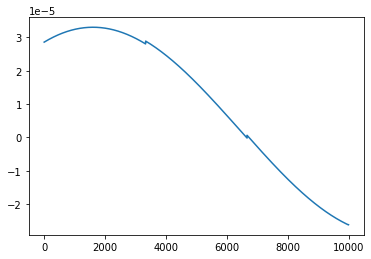

In [53]:
plt.plot(dddd[2])

In [220]:
fp_gpu-fp_real

array([-5.65375665e-05, -5.30453516e-05, -2.19071341e-05, -8.06043201e-06,
        3.47315427e-05,  3.07125366e-05,  8.66517929e-05,  2.81843600e-05,
       -5.43870591e-06, -7.04129506e-05])

In [221]:
fc_gpu-fc_real

array([-3.07599926e-05,  9.71602401e-06,  2.91876699e-05,  8.23354270e-05,
        4.93105117e-05,  5.77011522e-06, -3.33246178e-05, -5.21903564e-05,
       -2.03484881e-05, -5.99885284e-05])

In [222]:
dt_gpu - dt_real

array([ 5.31519273e-15, -8.26338550e-08, -1.48061706e-07,  6.03336825e-15,
       -5.53355255e-08, -9.16744686e-08,  6.08540995e-15, -2.79243491e-08,
       -4.00779232e-08,  5.50254287e-15])

In [44]:

class GWAntenna():
    def __init__(self, detector_name, device='cuda'):
        #self.det_bilby = sealgw.simulation.sealinterferometers.SealInterferometerList([detector_name])[0]
        self.det_bilby = bilby.gw.detector.InterferometerList([detector_name])[0]
        self.location = torch.from_numpy(self.det_bilby.vertex).type(torch.float64)
        self.detector_tensor = torch.from_numpy(self.det_bilby.geometry.detector_tensor).type(torch.float64)
        
        
    def response(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]
        #D = self.detector_tensor.unsqueeze(0).repeat(bs, 1, 1)
        D = self.detector_tensor
        
        X = torch.zeros(bs, 3).type(torch.float64)
        Y = torch.zeros(bs, 3).type(torch.float64)

        # Greenwich hour angle of source (radians).
        # gha = gps2gmst(gpstime) - ra
        # The greenwich_mean_sidereal_time / gps2gmst can not be parallized on GPU
        # because it in the end needs a builtin fundamental function time.gmtime().
        # Therefore we have to make sure that gpstime is (almost) the same in the batch
        gha = torch.zeros_like(gpstime) + bilby.gw.utils.greenwich_mean_sidereal_time(gpstime[0]) - ra

        # pre-compute trig functions
        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)
        cospsi = torch.cos(psi)
        sinpsi = torch.sin(psi)
    
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec



        #fp = torch.einsum('ij,ijk,ik->i', X, D, X) - torch.einsum('ij,ijk,ik->i', Y, D, Y)
        #fc = torch.einsum('ij,ijk,ik->i', X, D, Y) + torch.einsum('ij,ijk,ik->i', Y, D, X)
        
        fp = torch.einsum('ij,jk,ik->i', X, D, X) - torch.einsum('ij,jk,ik->i', Y, D, Y)
        fc = torch.einsum('ij,jk,ik->i', X, D, Y) + torch.einsum('ij,jk,ik->i', Y, D, X)

        return fp, fc
    
    def time_delay_from_geocenter(self, ra, dec, gpstime):
        #gmst = gps2gmst(gpstime)
        bs = ra.shape[0]
        #loc = self.location.unsqueeze(0).repeat(bs, 1)

        gmst = torch.zeros_like(gpstime) + bilby.gw.utils.greenwich_mean_sidereal_time(gpstime[0]) #- ra
        long = gmst - ra
        lat = dec
        
        wavevector = torch.zeros(bs, 3).type(torch.float64)
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -torch.cos(long)*torch.cos(lat), -torch.cos(long)*torch.sin(lat), -torch.sin(long)
        
        print(wavevector.shape)
        print(self.location.shape)
        #dt = torch.dot(wavevector,self.location.unsqueeze(-1)) / 299792458
        #dt = torch.matmul(wavevector, self.location) / 299792458
        dt = torch.einsum('ij,j->i', wavevector, self.location) / 299792458
        
        #dt=1
        return dt
